# Punctuation restoration
## Notebook 2, same as 1, but I gonna train the lstm with bidirectional=True

+ Bidirectional ON
+ Only literature, no news
+ Shorter sents (due to increased training time)

## Step 1: common preparation of textual data

Yttm will behave nicely with text with commas, separated by space from both sides. This approach misses some information, like common word endings that are followed by a comma, yet it may be simplier to implement.

**Important**: this shall be done for every training case. At the evaluation step text shall not contain any commas

In [2]:
import youtokentome as yttm
import pandas as pd
import numpy as np
import re

In [71]:
corpus = []

In [75]:
# the archive shall be pre-downloaded
# https://github.com/natasha/corus#load_taiga_proza
from corus import load_taiga_proza_metas, load_taiga_proza
from pathlib import Path
path = Path("~/datasets/corus/taiga/proza_ru.zip").expanduser()
if not path.parent.exists():
    path.parent.mkdir(parents=True, exist_ok=False)

metas = load_taiga_proza_metas(path, offset=0, count=80000)
records = load_taiga_proza(path, metas, offset=0, count=80000)

In [ ]:
corpus.extend([record.text.replace(",", " ,") for record in records])

In [74]:
len(corpus)

0

## Step 2: creating encoder
For such modified text data bpe encoder shall be trained separately, of course.

In [7]:
TOTAL_WORDS = 5000
BPE_MODEL_PATH = "bpe2.yttm"
def create_bpe_tokenizer_from_scratch(corpus, train_data_path="yttm_train_data.txt"):
    with open(train_data_path, "w") as _file:
        _file.writelines(corpus)
    # Training model
    # (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
    return yttm.BPE.train(data=train_data_path, vocab_size=TOTAL_WORDS, model=BPE_MODEL_PATH, n_threads=6)

In [8]:
bpe = create_bpe_tokenizer_from_scratch(" \n ".join(corpus))
COMMA = bpe.encode(" ,")[0] # COMMA token shall be fixed after each re-training

## Step 3: comma encoding algorithm

In [9]:
def encode_commas(sent):
    # for-loopish version can be optimized
    result = []
    for idx, token in enumerate(sent):
        if idx == len(sent) - 1:
            # no comma checking for last token
            result.append(0)
        else:
            if token == COMMA:
                continue
            elif sent[idx+1] == COMMA:
                result.append(1)
            else:
                result.append(0)
    return result

## Step 4: creating train data


1. Encode a sentence
2. Encode commas
3. Strip commas from encoded sentence
4. Ensure lengthes are equal

In [10]:
from razdel import sentenize
from tqdm import tqdm

In [36]:
# we dont need sents without commas
corpus_of_sents_with_commas = [ sent.strip() 
                               for text in corpus 
                               for sent in [s.text for s in sentenize(text)]
                               if "," in sent ]

In [39]:
encoded_corpus = []
tags = []
MAX_SEQUENCE_LENGTH = 90
for idx, sent in enumerate(corpus_of_sents_with_commas):
    encoded_sentence = bpe.encode(sent)
    
    if not COMMA in encoded_sentence:
        continue
           
    if encoded_sentence[0] == COMMA:
        # Normally shall not be the case
        # ... yet it is - direct speech gets separated leaving a chunks with leading commas
        continue
            
    taglist = encode_commas(encoded_sentence)
    encoded_sentence = list(filter(lambda x: x != COMMA, encoded_sentence))
    
    es_len = len(encoded_sentence)
    tl_len = len(taglist)
    
    if es_len > MAX_SEQUENCE_LENGTH:
        continue # I keep no hope the net will manage to comprehend such a lenthy chunk
    if es_len < 10:
        continue
        
    if es_len != tl_len:
        # this shall be examined and fixed without such workaround
        print(f"Lengthes do not match at {idx}: sentence has {es_len} and taglist has {tl_len}")
        continue
        
    encoded_corpus.append(encoded_sentence)
    tags.append(taglist)

Lengthes do not match at 83909: sentence has 26 and taglist has 27
Lengthes do not match at 226584: sentence has 46 and taglist has 47
Lengthes do not match at 799466: sentence has 27 and taglist has 28
Lengthes do not match at 806042: sentence has 10 and taglist has 11
Lengthes do not match at 1783144: sentence has 17 and taglist has 18
Lengthes do not match at 2142447: sentence has 37 and taglist has 38
Lengthes do not match at 2427291: sentence has 11 and taglist has 12
Lengthes do not match at 3495235: sentence has 12 and taglist has 13
Lengthes do not match at 3889172: sentence has 11 and taglist has 12
Lengthes do not match at 5095627: sentence has 26 and taglist has 27
Lengthes do not match at 5735518: sentence has 21 and taglist has 22
Lengthes do not match at 5963820: sentence has 17 and taglist has 18


In [45]:
# we can explore, what sents were misencoded
print(corpus_of_sents_with_commas[1783144])
print(corpus_of_sents_with_commas[226584])
print(corpus_of_sents_with_commas[3495235])
# ... well, seems to be okay to miss such sentences

Я-воздух , я-огонь , я-земля я-вода ,
ВСЕ БУДЕТ ХОРОШО , , , МЫ ВЫДЕРЖИМ , , , ВЕДЬ МЫ СИЛЬНЫЕ , , , ТЫ ЖЕ ЗНАЕШЬ , , , , МЫ ВМЕСТЕ , , ,
ПРОДОЛЖЕНИЕ СЛЕДУЕТ , , , , , , , , , , , , , , , , , , , ,


In [46]:
len(encoded_corpus)

5689804

In [47]:
assert len(tags) == len(encoded_corpus)

## Step 5: creating model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 24
VOCAB_SIZE    = TOTAL_WORDS
TAGSET_SIZE   = 2

In [17]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [53]:
# weighted loss function
zerocount = sum([len(a) - sum(a) for a in tags])
onecount = sum([sum(a) for a in tags])

class_divs = torch.tensor([zerocount, onecount], dtype=float)
norm = torch.norm(class_divs, p=2, dim=0).detach()

class_divs = class_divs.div(norm.expand_as(class_divs))
class_weights = torch.ones(2)

class_weights /= class_divs

print(class_weights.detach())

tensor([ 1.0033, 12.2661])


In [52]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
optimizer     = optim.SGD(model.parameters(), lr=0.01)

In [54]:
loss_function = nn.NLLLoss() 

In [20]:
loss_function = nn.NLLLoss(class_weights)

In [55]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

In [56]:
very_bad_sentences = []

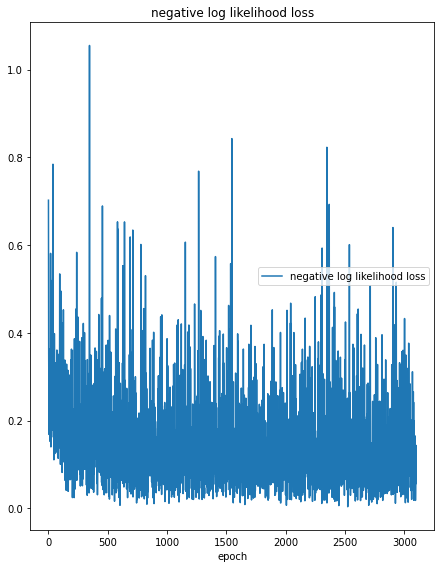

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.004, max:    1.055, cur:    0.065)
Iteration 3099000 of epoch 0


KeyboardInterrupt: 

In [57]:
for epoch in range(1): 
    for i, (text, taglist) in enumerate(zip(encoded_corpus, tags)):
        model.train()
        model.zero_grad()
        text = torch.tensor(text)
        taglist = torch.tensor(taglist)
        tag_scores = model(text)

        loss = loss_function(tag_scores, taglist)
        loss.backward()
        optimizer.step()
        if loss > 3:
            very_bad_sentences.append((text, np.argmax(tag_scores.detach().numpy(), axis=1)))
        
        if i % 1000 == 0:
            l = loss.detach().numpy()
            liveplot.update({"negative log likelihood loss": l})
            liveplot.draw()
            print(f"Iteration {i} of epoch {epoch}")

## Step 6: evaluation and inverse transformation

Now when we have a model predicting commas for us, it would be useful to inject those predictions right into our sentence.

idea: assume the pre-existing commas are correct, and fill in only missing ones.

In [58]:
def fill_in_commas(text):
    # ensure text accidentaly has no duplicated spaces
    text = re.sub("\s{2,}", " ", text)
    # encode text by bpe
    encoded_text = bpe.encode(text)
    # get predicted labels
    with torch.no_grad():
        predicted_tags = model.predict_tags(torch.tensor(encoded_text))
    # inject commas
    result = []
    for token, label in zip(encoded_text, predicted_tags):
        result.append(token)
        if label:
            result.append(COMMA)
    result = bpe.decode(result)[0]
    
    # return normal spacing
    result = result.replace(" ,", ",")
    # remove commas in the middle of words (this actually shall not be the case but nevertheless they are)
    result = re.sub("(?<=\w),(?=\w)", "", result)
    # same with commas right before punctuations
    result = re.sub(",(?=[.?!;:])", "", result)
    # and repeating commas (kinda ok, since we pass texts with commas)
    result = re.sub(",{2,}", ",", result)
    return result
    

In [59]:
fill_in_commas("Я не знаю что это такое однако могу предположить что что-то плохое.")

'Я не знаю, что это такое, однако могу предположить, что что-то плохое.'

In [60]:
fill_in_commas("Ой, ну это - да; надо убираться больше а ещё почухать его.")

'Ой, ну это - да; надо убираться больше, а ещё почухать его.'

In [61]:
fill_in_commas("Всё это очень долгое сложное неинтересное и непонятное.")

'Всё это очень долгое сложное неинтересное и непонятное.'

In [62]:
fill_in_commas("А когда все поймут будет уже поздно и мы сделаем своё дело как никто никогда раньше не делал.")

'А когда все поймут будет уже поздно, и мы сделаем своё дело, как никто никогда раньше не делал.'

## Saving the model

In [63]:
torch.save(model.state_dict(), 'lstm_tagger_bidirectional.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('lstm_tagger_bidirectional.pt'))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(5000, 32)
  (lstm): LSTM(32, 24, bidirectional=True)
  (hidden2tag): Linear(in_features=48, out_features=2, bias=True)
)